In [1]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import math
import os

%matplotlib inline

with open("calib/calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]

directory=2

left_movie = cv2.VideoCapture(f'movie/{directory}/left.mp4')
right_movie = cv2.VideoCapture(f'movie/{directory}/right.mp4')
rgb_movie = cv2.VideoCapture(f'movie/{directory}/rgb.mp4')
disparity = cv2.VideoCapture(f'movie/{directory}/disparity.mp4')
confmap = cv2.VideoCapture(f'movie/{directory}/conf.mp4')

left_movie.get(cv2.CAP_PROP_FPS),rgb_movie.get(cv2.CAP_PROP_FPS)

(30.00029977240357, 30.00029977240357)

In [2]:
bl = 7.5 #cm base line
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]
rcx 

643.5640258789062

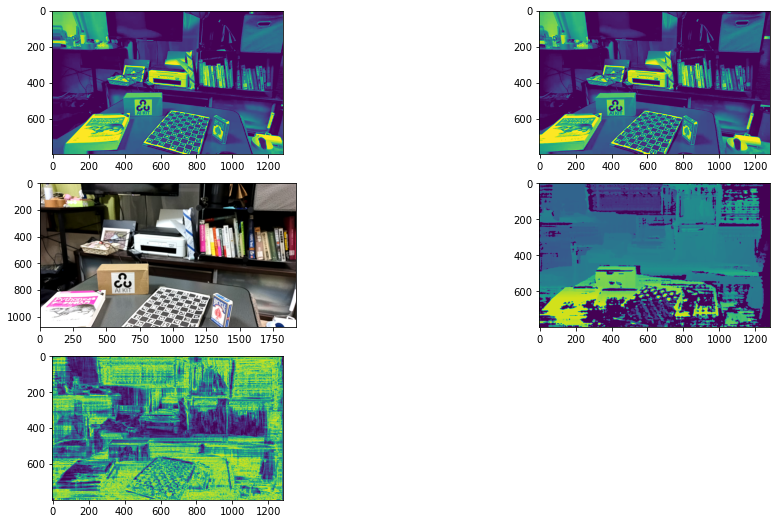

In [8]:
def getframes(frame_num,display=False):
    left_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    right_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    rgb_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    disparity.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
    confmap.set(cv2.CAP_PROP_POS_FRAMES,frame_num)

    
    left_ret, left_frame = left_movie.read()
    right_ret, right_frame = right_movie.read()
    rgb_ret,rgb_frame = rgb_movie.read()
#     rgb_frame = cv2.undistort(rgb_frame,np.array(rgb_data["intrinsicMatrix"]),np.array(rgb_data['distortionCoeff']))
#     left_frame = cv2.undistort(left_frame,np.array(left_data["intrinsicMatrix"]),np.array(left_data['distortionCoeff']))
#     right_frame = cv2.undistort(right_frame,np.array(right_data["intrinsicMatrix"]),np.array(right_data['distortionCoeff']))

    dis_ret,dis_frame = disparity.read()
    conf_ret,conf_frame = confmap.read()


    left_frame =cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_frame =cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)
    rgb_frame = cv2.cvtColor(rgb_frame,cv2.COLOR_BGRA2RGB)
    dis_frame = cv2.cvtColor(dis_frame,cv2.COLOR_BGR2GRAY)
    conf_frame = cv2.cvtColor(conf_frame,cv2.COLOR_BGR2GRAY)

    
    if display:
        plt.figure(figsize=(16,9))
        plt.subplot(321).imshow(left_frame,vmin=0, vmax=255)
        plt.subplot(322).imshow(right_frame,vmin=0, vmax=255)
        plt.subplot(323).imshow(rgb_frame)
        plt.subplot(324).imshow(dis_frame)
        plt.subplot(325).imshow(conf_frame)
        
#         plt.imshow(rgb_frame)
        plt.show()
    return left_frame,right_frame,rgb_frame,dis_frame,conf_frame


left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(20,display=True)

2574 matches found


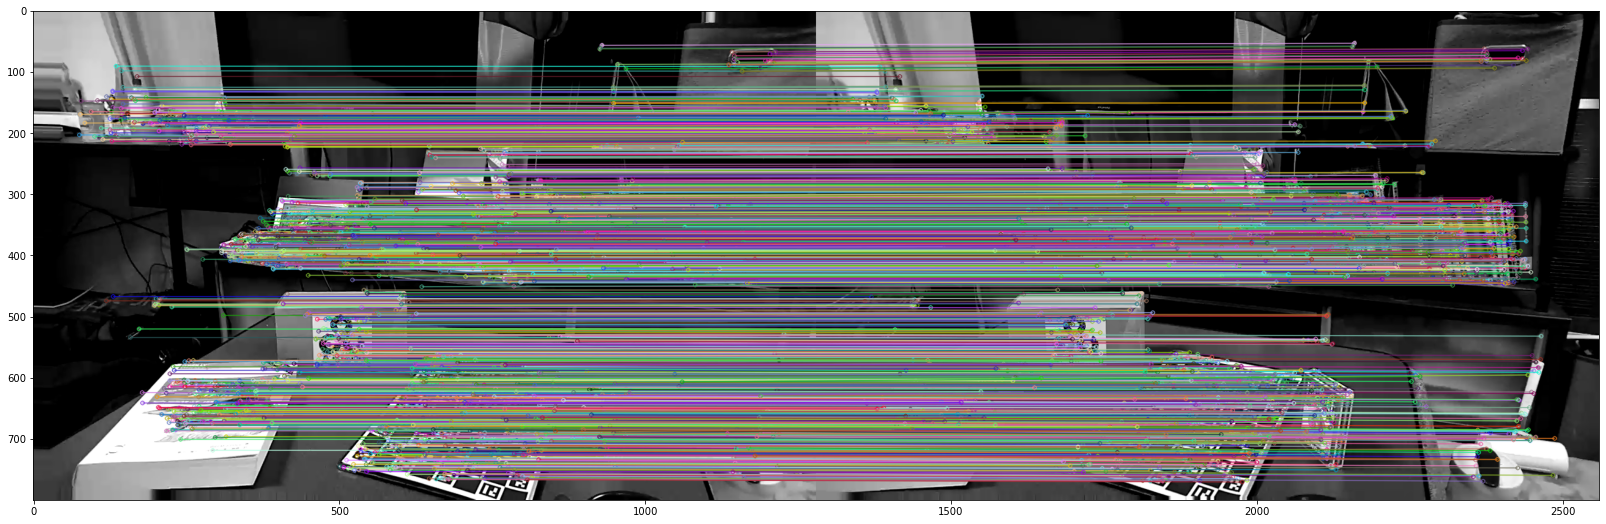

In [4]:
def akaze_compute(left_frame,right_frame,display=False):
    akaze = cv2.AKAZE_create() 
    akaze_left_kp, akaze_left_des = akaze.detectAndCompute(left_frame,None)
    akaze_right_kp, akaze_right_des = akaze.detectAndCompute(right_frame,None)
    akaze_bf = cv2.BFMatcher(crossCheck=True)
    akaze_matches = akaze_bf.match(akaze_left_des, akaze_right_des)
    akaze_matches = [i for i in akaze_matches if abs(akaze_left_kp[i.queryIdx].pt[1]-akaze_right_kp[i.trainIdx].pt[1])<10]
    if display:
        print(len(akaze_matches),"matches found")
        img_akaze = cv2.drawMatches(left_frame, akaze_left_kp, right_frame,akaze_right_kp, akaze_matches, None, flags=2)
        plt.figure(figsize=(32,9))
        plt.imshow(img_akaze)
        plt.show()
    return akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches
akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame,display=True)

カメラ\
右   +x\
下   +y\
正面 +z

In [5]:
def make_pcd(right_frame,dis_frame,conf_frame,filename,display=False):
    right_frame_rgb = cv2.applyColorMap(right_frame, cv2.COLORMAP_HOT)
    pointlist=[]
    colors=[]
    for xr in range(dis_frame.shape[0]):
        for yr in range(dis_frame.shape[1]):
            if conf_frame[xr][yr]<50 and dis_frame[xr][yr]>16and dis_frame[xr][yr]<96:
                d = dis_frame[xr][yr]
                z= rfx*bl/d
                x= (xr-rcx)*bl/d
                y= (yr-rcy)*bl/d
                color = right_frame_rgb[xr][yr]/256
                colors.append(color)
                p=[x,y,z]
                pointlist.append(p)
                
#                 rgbx=int((x-3.5)*rgb_fx/z + rgb_cx)
#                 rgby=int(y*rgb_fy/z + rgb_cy)
#                 if rgbx>=0 and rgby>=0:
#                     try :
#                         color = rgb_frame[rgbx][rgby]/256
#                         colors.append(color)
#                         p=[x,y,z]
#                         pointlist.append(p)
#                     except IndexError:
#                         pass
    pointlist=np.asarray(pointlist)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pointlist))
    pcd.colors= o3d.utility.Vector3dVector(np.array(colors))
    o3d.io.write_point_cloud(f"{filename}.ply", pcd)
    if display:
        o3d.visualization.draw_geometries([pcd])
    return pcd
pcd=make_pcd(right_frame,dis_frame,conf_frame,"./fpcd",display=True)

In [6]:
def akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches):
    positions = []
    right_descriptions = []
    right_kp = []
    for match in akaze_matches:
        left_ind=match.queryIdx
        right_ind=match.trainIdx
        left_pt=akaze_left_kp[left_ind].pt
        right_pt=akaze_right_kp[right_ind].pt
        d = left_pt[0]-right_pt[0]
        z=rfx*bl/d
        x= (right_pt[1]-rcx)*bl/d
        y=(right_pt[0]-rcy)*bl/d
        position=[x,y,z]
        description =akaze_right_des[right_ind]
        positions.append(position)
        right_descriptions.append(description)
        #! point!!
        right_kp.append(akaze_right_kp[right_ind])
    positions = np.asarray(positions)
    right_descriptions=np.asarray(right_descriptions)
    right_kp=np.asarray(right_kp)
    return positions,right_descriptions,right_kp

positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)
akazepcd = o3d.geometry.PointCloud()
akazepcd.points = o3d.utility.Vector3dVector(positions)
akazepcd.colors = o3d.utility.Vector3dVector(np.tile([1,0,0],[positions.shape[0],1]))

o3d.io.write_point_cloud("akazepcd.ply", akazepcd)

concatpcd = o3d.geometry.PointCloud()

pcdpoints = np.asarray(pcd.points)
pcdcolors = np.asarray(pcd.colors)
akazepoints = np.asarray(akazepcd.points)
akazecolors = np.asarray(akazepcd.colors)

concatpoints = np.concatenate([pcdpoints,akazepoints])
concatcolors = np.concatenate([pcdcolors,akazecolors])

concatpcd.points =  o3d.utility.Vector3dVector(np.array(concatpoints))
concatpcd.colors =  o3d.utility.Vector3dVector(np.array(concatcolors))

o3d.io.write_point_cloud("concatpcd.ply", concatpcd)

True

In [30]:
frame_count=int(left_movie.get(cv2.CAP_PROP_FRAME_COUNT))
for f in range(1293):
    print(f"now running frame {f}")
    left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(f)
    akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame)
    positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)
    try:
        os.mkdir(f"./frame/{str(f)}")
    except:
        pass
    make_pcd(right_frame,dis_frame,conf_frame,f"./frame/{str(f)}/color")
    np.savez(f"./frame/{str(f)}/pos_des_kp_frame",positions=positions,right_descriptions=right_descriptions,right_frame=right_frame)

now running frame 0
now running frame 1
now running frame 2
now running frame 3
now running frame 4
now running frame 5
now running frame 6
now running frame 7
now running frame 8
now running frame 9
now running frame 10
now running frame 11
now running frame 12
now running frame 13
now running frame 14
now running frame 15
now running frame 16
now running frame 17
now running frame 18
now running frame 19
now running frame 20
now running frame 21
now running frame 22
now running frame 23
now running frame 24
now running frame 25
now running frame 26
now running frame 27
now running frame 28
now running frame 29
now running frame 30
now running frame 31
now running frame 32
now running frame 33
now running frame 34
now running frame 35
now running frame 36
now running frame 37
now running frame 38
now running frame 39
now running frame 40
now running frame 41
now running frame 42
now running frame 43
now running frame 44
now running frame 45
now running frame 46
now running frame 47
no

now running frame 378
now running frame 379
now running frame 380
now running frame 381
now running frame 382
now running frame 383
now running frame 384
now running frame 385
now running frame 386
now running frame 387
now running frame 388
now running frame 389
now running frame 390
now running frame 391
now running frame 392
now running frame 393
now running frame 394
now running frame 395
now running frame 396
now running frame 397
now running frame 398
now running frame 399
now running frame 400
now running frame 401
now running frame 402
now running frame 403
now running frame 404
now running frame 405
now running frame 406
now running frame 407
now running frame 408
now running frame 409
now running frame 410
now running frame 411
now running frame 412
now running frame 413
now running frame 414
now running frame 415
now running frame 416
now running frame 417
now running frame 418
now running frame 419
now running frame 420
now running frame 421
now running frame 422
now runnin

now running frame 751
now running frame 752
now running frame 753
now running frame 754
now running frame 755
now running frame 756
now running frame 757
now running frame 758
now running frame 759
now running frame 760
now running frame 761
now running frame 762
now running frame 763
now running frame 764
now running frame 765
now running frame 766
now running frame 767
now running frame 768
now running frame 769
now running frame 770
now running frame 771
now running frame 772
now running frame 773
now running frame 774
now running frame 775
now running frame 776
now running frame 777
now running frame 778
now running frame 779
now running frame 780
now running frame 781
now running frame 782
now running frame 783
now running frame 784
now running frame 785
now running frame 786
now running frame 787
now running frame 788
now running frame 789
now running frame 790
now running frame 791
now running frame 792
now running frame 793
now running frame 794
now running frame 795
now runnin

now running frame 1119
now running frame 1120
now running frame 1121
now running frame 1122
now running frame 1123
now running frame 1124
now running frame 1125
now running frame 1126
now running frame 1127
now running frame 1128
now running frame 1129
now running frame 1130
now running frame 1131
now running frame 1132
now running frame 1133
now running frame 1134
now running frame 1135
now running frame 1136
now running frame 1137
now running frame 1138
now running frame 1139
now running frame 1140
now running frame 1141
now running frame 1142
now running frame 1143
now running frame 1144
now running frame 1145
now running frame 1146
now running frame 1147
now running frame 1148
now running frame 1149
now running frame 1150
now running frame 1151
now running frame 1152
now running frame 1153
now running frame 1154
now running frame 1155
now running frame 1156
now running frame 1157
now running frame 1158
now running frame 1159
now running frame 1160
now running frame 1161
now running

In [29]:
def frame_data(f):
    left_frame,right_frame,rgb_frame,dis_frame,conf_frame =getframes(f)
    akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches=akaze_compute(left_frame,right_frame)    
    pcd=make_pcd(rgb_frame,dis_frame,conf_frame,"./fpcd")
    positions,right_descriptions,right_kp=akaze_3d_position(akaze_left_kp, akaze_left_des,akaze_right_kp, akaze_right_des,akaze_matches)
    
    np.random.seed(f)
    c = np.random.rand(3)
    akazepcd = o3d.geometry.PointCloud()
    akazepcd.points = o3d.utility.Vector3dVector(positions)
    akazepcd.colors = o3d.utility.Vector3dVector(np.tile(c,[positions.shape[0],1]))

    concatpcd = o3d.geometry.PointCloud()

    pcdpoints = np.asarray(pcd.points)
    pcdcolors = np.asarray(pcd.colors)
    akazepoints = np.asarray(akazepcd.points)
    akazecolors = np.asarray(akazepcd.colors)

    concatpoints = np.concatenate([pcdpoints,akazepoints])
    concatcolors = np.concatenate([pcdcolors,akazecolors])

    concatpcd.points =  o3d.utility.Vector3dVector(np.array(concatpoints))
    concatpcd.colors =  o3d.utility.Vector3dVector(np.array(concatcolors))
    
    result = {
        "left_frame":left_frame,
        "right_frame":right_frame,
        "rgb_frame":rgb_frame,
        "dis_frame":dis_frame,
        "conf_frame":conf_frame,
        "akaze_left_kp":akaze_left_kp,
        "akaze_left_des":akaze_left_des,
        "akaze_right_kp":akaze_right_kp,
        "akaze_right_des":akaze_right_des,
        "akaze_matches":akaze_matches,
        "pcd":pcd,
        "positions":positions,
        "right_descriptions":right_descriptions,
        "right_kp":right_kp,
        "akazepcd":akazepcd,
        "concatpcd":concatpcd
    }
    return result

t1_frame = frame_data(40)
t2_frame = frame_data(41)

In [30]:
def match_by_frame(t1_descriptions,t2_descriptions):
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(t1_descriptions,t2_descriptions)
    good_matches = sorted(matches, key=lambda x: x.distance)
    return good_matches
good_matches = match_by_frame(t1_frame["right_descriptions"],t2_frame["right_descriptions"])
len(good_matches)

1907

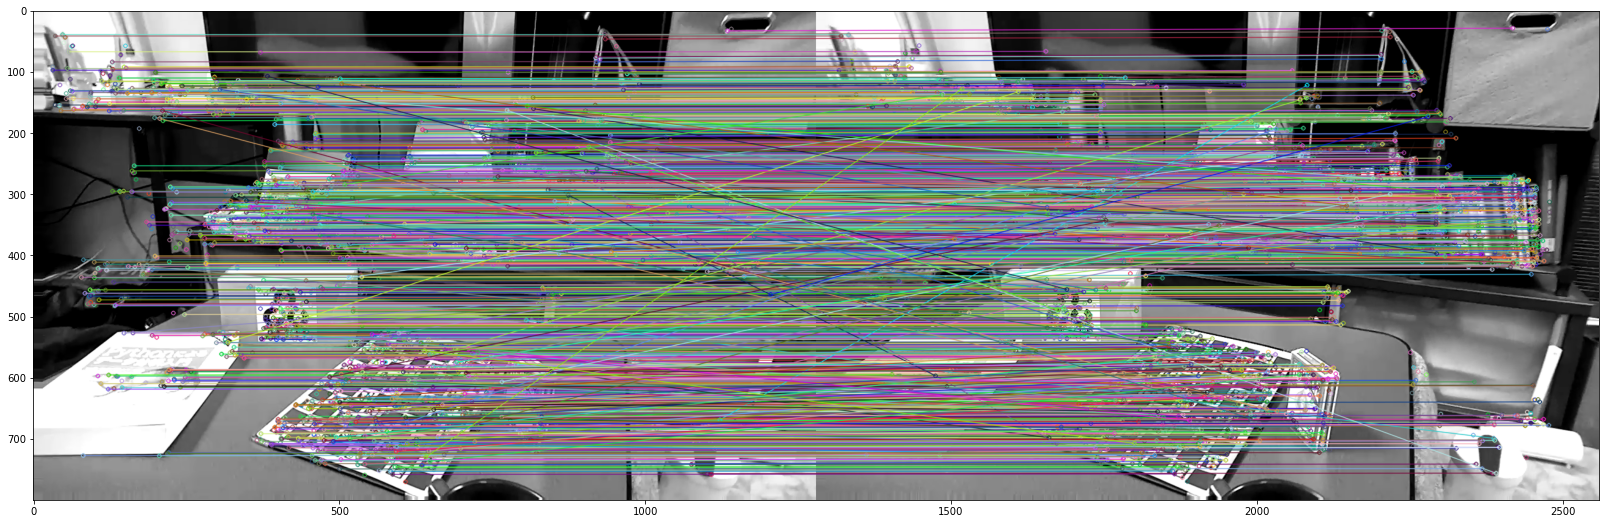

In [31]:
img=cv2.drawMatches(t1_frame["right_frame"],t1_frame["right_kp"],t2_frame["right_frame"],t2_frame["right_kp"],good_matches,None)
plt.figure(figsize=(32,9))
plt.imshow(img)

In [36]:
# def gause(x):
#     y=1/math.sqrt(2*math.pi)*np.exp(-((x/50)**2)/2)
#     return y
# def affinM(t1_positions,t2_positions,good_matches):
#     t1_3d_points=[]
#     t2_3d_points=[]
#     confidence = []
#     for match in good_matches:
#         t1_3d_points.append(t1_positions[match.queryIdx])
#         t2_3d_points.append(t2_positions[match.trainIdx])
#         c = gause(match.distance)
#         confidence.append([c,c,c])
#     t1_3d_points=np.array(t1_3d_points)
#     t2_3d_points=np.array(t2_3d_points)
#     confidence=np.array(confidence)
#     Y0 =np.sum(t1_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
#     X0 =np.sum(t2_3d_points*confidence,axis=0)/np.sum(confidence,axis=0)
#     H = (t1_3d_points-Y0).T@(t2_3d_points-X0)
#     U, s, V = np.linalg.svd(H, full_matrices=False)
    
#     R=U@V
#     T=Y0-R@X0
#     M=np.array([
#         [R[0][0],R[0][1],R[0][2],T[0]],
#         [R[1][0],R[1][1],R[1][2],T[1]],
#         [R[2][0],R[2][1],R[2][2],T[2]],
#         [0,0,0,1]
#     ])

#     return M

# print(len(t1_frame["positions"]))
# print(len(good_matches))
# M = affinM(t1_frame["positions"],t2_frame["positions"],good_matches)
# M

In [32]:
def gause(x):
    y=1/math.sqrt(2*math.pi)*np.exp(-((x/50)**2)/2)
    return y
def affinM(t1_positions,t2_positions,good_matches):
    t1_3d_points=[]
    t2_3d_points=[]
    confidence = []
    for match in good_matches:
        t1_3d_points.append(t1_positions[match.queryIdx])
        t2_3d_points.append(t2_positions[match.trainIdx])
    t1_3d_points=np.array(t1_3d_points)
    t2_3d_points=np.array(t2_3d_points)
    Y0 =np.mean(t1_3d_points,axis=0)
    X0 =np.mean(t2_3d_points,axis=0)
    H = (t1_3d_points-Y0).T@(t2_3d_points-X0)
    U, s, V = np.linalg.svd(H, full_matrices=False)
    
    R=U@V
    T=Y0-R@X0
    M=np.array([
        [R[0][0],R[0][1],R[0][2],T[0]],
        [R[1][0],R[1][1],R[1][2],T[1]],
        [R[2][0],R[2][1],R[2][2],T[2]],
        [0,0,0,1]
    ])
    return M

def ransac_affinM(t1_positions,t2_positions,good_matches):
    tryout = 100
    best_count = 0
    bestDistances = None

    matched_t1 = np.asarray([t1_positions[match.queryIdx] for match in good_matches])
    matched_t2 = np.asarray([t2_positions[match.trainIdx] for match in good_matches])

    for i in range(tryout):
        small_good_matches = np.random.choice(good_matches,5)
        
        small_M = affinM(t1_positions,t2_positions,small_good_matches)

        pre_matched_t2 = fit_affinM(matched_t2,small_M)

        distances = np.linalg.norm(matched_t1-pre_matched_t2,axis=1)
        new_count = np.count_nonzero(distances < 10)

        if new_count > best_count:
            best_count = new_count
            bestDistances = distances
    
    best_matches = []
    for i in range(len(bestDistances)):
        if bestDistances[i]<10:
            best_matches.append(good_matches[i])
    M = affinM(t1_positions,t2_positions,best_matches)
    print(f"{len(best_matches)} matches was used for this")
    return M

M = ransac_affinM(t1_frame["positions"],t2_frame["positions"],good_matches)
M

1764 matches was used for this


array([[ 9.99999291e-01,  3.80398836e-04,  1.12834528e-03,
         5.04885046e-02],
       [-3.73622742e-04,  9.99981933e-01, -5.99948088e-03,
         5.08626771e-01],
       [-1.13060709e-03,  5.99905505e-03,  9.99981366e-01,
        -5.06149032e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [33]:
def fit_affinM(positions,M):
    homo_points=np.concatenate([positions,np.ones((positions.shape[0],1))],1).T
    newp=(M@homo_points).T[:,:-1]
    return newp
newp=fit_affinM(t2_frame["positions"],M)

In [34]:
def checkM(t1_pos,t2_pos,newp):
    cpcd = np.concatenate([t1_pos,t2_pos,newp])
    g = np.tile([0,1,0],[t1_pos.shape[0],1])
    b = np.tile([0,0,1],[t2_pos.shape[0],1])
    r = np.tile([1,0,0],[newp.shape[0],1])
    cpcdc =   np.concatenate([g,b,r])
    checkpcd = o3d.geometry.PointCloud()
    checkpcd.points = o3d.utility.Vector3dVector(cpcd)
    checkpcd.colors = o3d.utility.Vector3dVector(cpcdc)
    o3d.io.write_point_cloud("checkpcd.ply", checkpcd )
checkM(t2_frame["positions"],t2_frame["positions"],newp)

In [35]:
Mlist=[]
last_frame_position=None
last_frame_descriptions=None
numberofappearrence=[]
for i in range(1290):
    print("Now cal : ",i)
    t1=np.load(f"./frame/{i}/pos_des_kp_frame.npz")
    t1_positions=t1['positions']
    t1_descriptions=t1["right_descriptions"]
    if i == 0:
        last_frame_position= t1_positions
        last_frame_descriptions=t1_descriptions
    else:
        good_matches=match_by_frame(last_frame_descriptions,t1_descriptions)
        matched_ind = [match.trainIdx for match in good_matches]
        print(len(good_matches)," matches")
        if len(good_matches)<100:
            M = Mlist[-1]
        else:
            M=ransac_affinM(last_frame_position,t1_positions,good_matches)
        
        newp = fit_affinM(t1_positions,M)
        last_frame_descriptions=t1_descriptions
        last_frame_position=newp
        Mlist.append(M)

Now cal :  0
Now cal :  1
781  matches
719 matches was used for this
Now cal :  2
729  matches
630 matches was used for this
Now cal :  3
783  matches
685 matches was used for this
Now cal :  4
798  matches
710 matches was used for this
Now cal :  5
774  matches
687 matches was used for this
Now cal :  6
769  matches
681 matches was used for this
Now cal :  7
806  matches
714 matches was used for this
Now cal :  8
608  matches
330 matches was used for this
Now cal :  9
627  matches
56 matches was used for this
Now cal :  10
1310  matches
1232 matches was used for this
Now cal :  11
1394  matches
1315 matches was used for this
Now cal :  12
1502  matches
1442 matches was used for this
Now cal :  13
1465  matches
1403 matches was used for this
Now cal :  14
1456  matches
1393 matches was used for this
Now cal :  15
1449  matches
1395 matches was used for this
Now cal :  16
1489  matches
1438 matches was used for this
Now cal :  17
1523  matches
1450 matches was used for this
Now cal :  1

508  matches
393 matches was used for this
Now cal :  142
432  matches
313 matches was used for this
Now cal :  143
397  matches
265 matches was used for this
Now cal :  144
631  matches
501 matches was used for this
Now cal :  145
820  matches
684 matches was used for this
Now cal :  146
743  matches
554 matches was used for this
Now cal :  147
956  matches
807 matches was used for this
Now cal :  148
946  matches
806 matches was used for this
Now cal :  149
1161  matches
1071 matches was used for this
Now cal :  150
1122  matches
1025 matches was used for this
Now cal :  151
1213  matches
1133 matches was used for this
Now cal :  152
1161  matches
1073 matches was used for this
Now cal :  153
1123  matches
1033 matches was used for this
Now cal :  154
1234  matches
1160 matches was used for this
Now cal :  155
1066  matches
963 matches was used for this
Now cal :  156
1039  matches
927 matches was used for this
Now cal :  157
1198  matches
1111 matches was used for this
Now cal :  15

1139 matches was used for this
Now cal :  280
1113  matches
1042 matches was used for this
Now cal :  281
1178  matches
1127 matches was used for this
Now cal :  282
706  matches
586 matches was used for this
Now cal :  283
716  matches
623 matches was used for this
Now cal :  284
870  matches
758 matches was used for this
Now cal :  285
857  matches
743 matches was used for this
Now cal :  286
779  matches
668 matches was used for this
Now cal :  287
761  matches
688 matches was used for this
Now cal :  288
800  matches
735 matches was used for this
Now cal :  289
777  matches
667 matches was used for this
Now cal :  290
835  matches
726 matches was used for this
Now cal :  291
693  matches
607 matches was used for this
Now cal :  292
578  matches
492 matches was used for this
Now cal :  293
707  matches
660 matches was used for this
Now cal :  294
638  matches
591 matches was used for this
Now cal :  295
595  matches
536 matches was used for this
Now cal :  296
684  matches
648 match

1107 matches was used for this
Now cal :  421
1171  matches
1095 matches was used for this
Now cal :  422
1007  matches
903 matches was used for this
Now cal :  423
1266  matches
1219 matches was used for this
Now cal :  424
1005  matches
912 matches was used for this
Now cal :  425
1207  matches
1133 matches was used for this
Now cal :  426
1046  matches
951 matches was used for this
Now cal :  427
1151  matches
1093 matches was used for this
Now cal :  428
1100  matches
1030 matches was used for this
Now cal :  429
887  matches
799 matches was used for this
Now cal :  430
1114  matches
1065 matches was used for this
Now cal :  431
1044  matches
979 matches was used for this
Now cal :  432
1042  matches
975 matches was used for this
Now cal :  433
982  matches
903 matches was used for this
Now cal :  434
657  matches
528 matches was used for this
Now cal :  435
887  matches
805 matches was used for this
Now cal :  436
926  matches
845 matches was used for this
Now cal :  437
952  matc

1237 matches was used for this
Now cal :  559
1260  matches
1207 matches was used for this
Now cal :  560
1171  matches
1086 matches was used for this
Now cal :  561
1343  matches
1304 matches was used for this
Now cal :  562
1307  matches
1235 matches was used for this
Now cal :  563
1350  matches
1288 matches was used for this
Now cal :  564
1236  matches
1165 matches was used for this
Now cal :  565
1142  matches
1053 matches was used for this
Now cal :  566
1253  matches
1157 matches was used for this
Now cal :  567
1400  matches
1326 matches was used for this
Now cal :  568
1255  matches
1139 matches was used for this
Now cal :  569
1297  matches
1203 matches was used for this
Now cal :  570
1185  matches
1088 matches was used for this
Now cal :  571
1189  matches
1104 matches was used for this
Now cal :  572
1358  matches
1264 matches was used for this
Now cal :  573
1404  matches
1313 matches was used for this
Now cal :  574
1371  matches
1239 matches was used for this
Now cal :

1149 matches was used for this
Now cal :  698
1562  matches
1435 matches was used for this
Now cal :  699
1525  matches
1360 matches was used for this
Now cal :  700
1742  matches
1603 matches was used for this
Now cal :  701
1303  matches
1104 matches was used for this
Now cal :  702
1146  matches
934 matches was used for this
Now cal :  703
1083  matches
880 matches was used for this
Now cal :  704
1278  matches
1159 matches was used for this
Now cal :  705
1365  matches
1237 matches was used for this
Now cal :  706
1241  matches
1072 matches was used for this
Now cal :  707
1349  matches
1181 matches was used for this
Now cal :  708
1377  matches
1223 matches was used for this
Now cal :  709
1448  matches
1337 matches was used for this
Now cal :  710
1496  matches
1394 matches was used for this
Now cal :  711
1347  matches
1234 matches was used for this
Now cal :  712
1062  matches
903 matches was used for this
Now cal :  713
1432  matches
1339 matches was used for this
Now cal :  7

1142 matches was used for this
Now cal :  838
1206  matches
1148 matches was used for this
Now cal :  839
1218  matches
1142 matches was used for this
Now cal :  840
863  matches
750 matches was used for this
Now cal :  841
804  matches
641 matches was used for this
Now cal :  842
421  matches
195 matches was used for this
Now cal :  843
383  matches
306 matches was used for this
Now cal :  844
463  matches
421 matches was used for this
Now cal :  845
407  matches
333 matches was used for this
Now cal :  846
491  matches
330 matches was used for this
Now cal :  847
569  matches
445 matches was used for this
Now cal :  848
764  matches
731 matches was used for this
Now cal :  849
585  matches
521 matches was used for this
Now cal :  850
549  matches
444 matches was used for this
Now cal :  851
528  matches
423 matches was used for this
Now cal :  852
596  matches
529 matches was used for this
Now cal :  853
862  matches
822 matches was used for this
Now cal :  854
757  matches
664 match

206 matches was used for this
Now cal :  978
263  matches
205 matches was used for this
Now cal :  979
474  matches
416 matches was used for this
Now cal :  980
523  matches
470 matches was used for this
Now cal :  981
499  matches
432 matches was used for this
Now cal :  982
440  matches
362 matches was used for this
Now cal :  983
594  matches
541 matches was used for this
Now cal :  984
582  matches
511 matches was used for this
Now cal :  985
636  matches
570 matches was used for this
Now cal :  986
562  matches
479 matches was used for this
Now cal :  987
683  matches
621 matches was used for this
Now cal :  988
694  matches
623 matches was used for this
Now cal :  989
715  matches
649 matches was used for this
Now cal :  990
573  matches
476 matches was used for this
Now cal :  991
616  matches
528 matches was used for this
Now cal :  992
703  matches
618 matches was used for this
Now cal :  993
908  matches
827 matches was used for this
Now cal :  994
1056  matches
989 matches w

779 matches was used for this
Now cal :  1115
814  matches
652 matches was used for this
Now cal :  1116
609  matches
438 matches was used for this
Now cal :  1117
703  matches
614 matches was used for this
Now cal :  1118
627  matches
517 matches was used for this
Now cal :  1119
764  matches
693 matches was used for this
Now cal :  1120
635  matches
564 matches was used for this
Now cal :  1121
594  matches
497 matches was used for this
Now cal :  1122
766  matches
689 matches was used for this
Now cal :  1123
857  matches
781 matches was used for this
Now cal :  1124
892  matches
817 matches was used for this
Now cal :  1125
787  matches
697 matches was used for this
Now cal :  1126
795  matches
693 matches was used for this
Now cal :  1127
764  matches
666 matches was used for this
Now cal :  1128
852  matches
784 matches was used for this
Now cal :  1129
813  matches
733 matches was used for this
Now cal :  1130
911  matches
838 matches was used for this
Now cal :  1131
895  match

1222 matches was used for this
Now cal :  1253
1352  matches
1304 matches was used for this
Now cal :  1254
1419  matches
1385 matches was used for this
Now cal :  1255
1243  matches
1195 matches was used for this
Now cal :  1256
1066  matches
1027 matches was used for this
Now cal :  1257
993  matches
951 matches was used for this
Now cal :  1258
896  matches
857 matches was used for this
Now cal :  1259
882  matches
845 matches was used for this
Now cal :  1260
882  matches
826 matches was used for this
Now cal :  1261
974  matches
911 matches was used for this
Now cal :  1262
1031  matches
972 matches was used for this
Now cal :  1263
884  matches
828 matches was used for this
Now cal :  1264
864  matches
812 matches was used for this
Now cal :  1265
927  matches
873 matches was used for this
Now cal :  1266
876  matches
806 matches was used for this
Now cal :  1267
897  matches
851 matches was used for this
Now cal :  1268
885  matches
831 matches was used for this
Now cal :  1269


In [36]:
Mlist=np.asarray(Mlist)
np.save("affin_list",Mlist)

In [37]:
all_points=None
all_colors=None
b = 100
e =400
s = 10
for i in range(b,e,s):
    pcd = o3d.io.read_point_cloud(f"./frame/{str(i)}/color.ply")
    points=np.asarray(pcd.points)
    homo_points=np.concatenate([points,np.ones((points.shape[0],1))],1).T
    colors=np.asarray(pcd.colors)
    if i==b:
        if b ==0:
            all_points=points
            all_colors=colors
        else:
            newp=fit_affinM(points,Mlist[i-1])
            all_points=newp
            all_colors=colors
    else:
        print("adding frame :",i)
        newp=fit_affinM(points,Mlist[i-1])
        all_points=np.concatenate([all_points,newp])
        all_colors= np.concatenate([all_colors,colors])
all_pcd = o3d.geometry.PointCloud()
all_pcd.points = o3d.utility.Vector3dVector(all_points)
all_pcd.colors= o3d.utility.Vector3dVector(all_colors)
o3d.io.write_point_cloud("./test2.ply", all_pcd)

adding frame : 110
adding frame : 120
adding frame : 130
adding frame : 140
adding frame : 150
adding frame : 160
adding frame : 170
adding frame : 180
adding frame : 190
adding frame : 200
adding frame : 210
adding frame : 220
adding frame : 230
adding frame : 240
adding frame : 250
adding frame : 260
adding frame : 270
adding frame : 280
adding frame : 290
adding frame : 300
adding frame : 310
adding frame : 320
adding frame : 330
adding frame : 340
adding frame : 350
adding frame : 360
adding frame : 370
adding frame : 380
adding frame : 390


True

In [389]:
M = affinM(t1["positions"],newp,good_matches)
newp=fit_affinM(newp,M)
print(M)

[[ 1.00000000e+00  6.86869315e-16 -1.62386485e-15  8.52651283e-14]
 [-7.92302158e-16  1.00000000e+00  1.66820801e-16  9.23705556e-14]
 [ 1.83051305e-15 -9.82223947e-17  1.00000000e+00  2.84217094e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


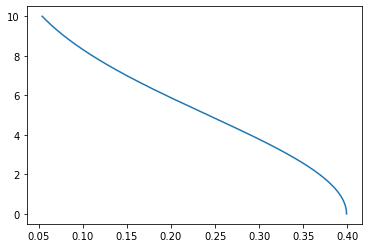

In [17]:
a = np.random.random_sample(100000)
a = np.sort(a*10)
def gause(x):
    y=1/math.sqrt(2*math.pi)*np.exp(-((x/5)**2)/2)
    return y
b = np.apply_along_axis(gause,0,a)
plt.plot(b,a)